# Import

In [243]:
import pandas as pd
import numpy as np
import time
import torch

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from datasets import concatenate_datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from itertools import permutations
import random
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

In [244]:
BATCH_SIZE = 64
torch.set_printoptions(precision=4, sci_mode=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [245]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [246]:
import sys
sys.path.append('./Anomaly Detection Framework')

import utils
import tac
import bert_embedding as be
import evaluation as ev
import baseline 

# Data Loading

In [250]:
# full_dataset_ : not return train and test split but returning all the samples in one DataLoader Object
train_20ng, test_20ng = utils.import_dataset(name="20NewsGroups", batch_size=BATCH_SIZE)
train_reuters, test_reuters = utils.import_dataset(name="Reuters", batch_size=BATCH_SIZE)
train_wos = utils.import_dataset(name="WOS", batch_size=BATCH_SIZE)
train_dbpedia, test_dbpedia = utils.import_dataset(name="DBpedia14", batch_size=BATCH_SIZE)
train_agnews, test_agnews = utils.import_dataset(name="AGNews", batch_size=BATCH_SIZE)

20NewsGroups dataset importing .... 




Repo card metadata block was not found. Setting CardData to empty.


Reuters dataset importing .... 


WOS dataset importing .... 


DBpedia14 dataset importing .... 


AGNews dataset importing .... 




In [251]:
dl_20ng = utils.import_dataset(name="20NewsGroups", full_dataset_=True, batch_size=BATCH_SIZE)
dl_reuters = utils.import_dataset(name="Reuters", full_dataset_=True, batch_size=BATCH_SIZE)
dl_wos = utils.import_dataset(name="WOS", batch_size=BATCH_SIZE)
dl_dbpedia = utils.import_dataset(name="DBpedia14", full_dataset_=True, batch_size=BATCH_SIZE)
dl_agnews = utils.import_dataset(name="AGNews", full_dataset_=True, batch_size=BATCH_SIZE)

20NewsGroups dataset importing .... 




Repo card metadata block was not found. Setting CardData to empty.


Reuters dataset importing .... 


WOS dataset importing .... 


DBpedia14 dataset importing .... 


AGNews dataset importing .... 




In [252]:
label_text_value_, label_text_counts_ = np.unique(ds_20ng.dataset[:]['label_text'],return_counts=True)

# the most frequent label text
print(label_text_value_[np.argsort(label_text_counts_)[::-1]])
print()
print(label_text_counts_[np.argsort(label_text_counts_)[::-1]])

['comp.windows.x' 'rec.sport.hockey' 'soc.religion.christian'
 'rec.motorcycles' 'comp.sys.ibm.pc.hardware' 'sci.crypt' 'sci.med'
 'misc.forsale' 'sci.electronics' 'rec.sport.baseball' 'sci.space'
 'comp.graphics' 'comp.os.ms-windows.misc' 'rec.autos'
 'comp.sys.mac.hardware' 'talk.politics.mideast' 'talk.politics.guns'
 'alt.atheism' 'talk.politics.misc' 'talk.religion.misc']

[980 974 974 969 963 962 960 959 956 956 954 953 947 935 928 917 885 779
 755 605]


# Textual Anomaly Contamination

## 20NewsGroups

### Pantin Method

In [110]:
inlier_topic = "rec.sport.hockey"
anomaly_type = "contexual"
nb_documents = 1200
anomaly_rate = 0.2

train_dataset_AD_contexual = tac.textual_anomaly_contamination(ds_20ng, inlier_topic, anomaly_type, nb_documents, anomaly_rate, BATCH_SIZE)
train_dataset_AD_contexual.dataset

Dataset({
    features: ['text', 'label', 'label_text', 'anomaly_label'],
    num_rows: 1200
})

In [111]:
inlier_topic = "rec.sport.hockey"
anomaly_type = "independent"
nb_documents = 1200
anomaly_rate = 0.2

train_dataset_AD_independent = tac.textual_anomaly_contamination(ds_20ng, inlier_topic, anomaly_type, nb_documents, anomaly_rate, BATCH_SIZE)
train_dataset_AD_independent.dataset

Dataset({
    features: ['text', 'label', 'label_text', 'anomaly_label'],
    num_rows: 1200
})

In [171]:
inlier_topic = 'sports'

train_20ng_intlier, train_20ng_anomaly = tac.textual_anomaly_contamination_20newsgroups(train_20ng.dataset, inlier_topic, batch_size=64, type_tac='pantin')

print(train_20ng_intlier.dataset)
print(train_20ng_anomaly.dataset)

Dataset({
    features: ['text', 'label', 'label_text', 'topic_label_text', 'anomaly_label'],
    num_rows: 1159
})
Dataset({
    features: ['text', 'label', 'label_text', 'topic_label_text', 'anomaly_label'],
    num_rows: 9845
})


### Ruff Method


├── ***computer*** 
│   └── comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, comp.windows.x  

├── ***recreation***  
│   └── rec.autos, rec.motorcycles, rec.sport.baseball, rec.sport.hockey  

├── ***science***  
│   └── sci.crypt, sci.electronics, sci.med, sci.space  

├── ***miscellaneous***  
│   └── misc.forsale  

├── ***politics***
│   └── talk.politics.misc, talk.politics.guns, talk.politics.mideast  

└── ***religion***  
    └── talk.religion.misc, alt.atheism, soc.religion.christian


In [170]:
inlier_topic = 'recreation'

train_20ng_intlier, train_20ng_anomaly = tac.textual_anomaly_contamination_20newsgroups(train_20ng.dataset, inlier_topic, batch_size=64, type_tac='ruff')

print(train_20ng_intlier.dataset)
print(train_20ng_anomaly.dataset)

Dataset({
    features: ['text', 'label', 'label_text', 'topic_label_text', 'anomaly_label'],
    num_rows: 2304
})
Dataset({
    features: ['text', 'label', 'label_text', 'topic_label_text', 'anomaly_label'],
    num_rows: 8700
})


## Reuters

### Pantin Method


├── ***COMMODITIES***  
│   └── acq, cocoa, coffee, cotton, ...  

├── ***FINANCIAL***  
│   └── cpi, dlr, earn, income, ...  

├── ***METALS***
│   └── copper, gold, nickel, ...  

└──  ***ENERGY***
    └── crude, fuel, nat-gas, propane


In [163]:
inlier_topic = 'energy'

train_reuters_intlier, train_reuters_anomaly = tac.textual_anomaly_contamination_reuters(train_reuters.dataset, inlier_topic, type_tac='pantin')

print(train_reuters_intlier.dataset)
print(train_reuters_anomaly.dataset)

Dataset({
    features: ['text', 'text_type', 'topics', 'lewis_split', 'cgis_split', 'old_id', 'new_id', 'places', 'people', 'orgs', 'exchanges', 'date', 'title', 'parent_topic'],
    num_rows: 437
})
Dataset({
    features: ['text', 'text_type', 'topics', 'lewis_split', 'cgis_split', 'old_id', 'new_id', 'places', 'people', 'orgs', 'exchanges', 'date', 'title', 'parent_topic'],
    num_rows: 8701
})


### Ruff Method

In [119]:
inlier_topic = 'acq'

train_reuters_intlier, train_reuters_anomaly = tac.textual_anomaly_contamination_reuters(train_reuters.dataset, inlier_topic, batch_size=64, type_tac='ruff')

print(train_reuters_intlier.dataset)
print(train_reuters_anomaly.dataset)

Dataset({
    features: ['text', 'text_type', 'topics', 'lewis_split', 'cgis_split', 'old_id', 'new_id', 'places', 'people', 'orgs', 'exchanges', 'date', 'title'],
    num_rows: 2292
})
Dataset({
    features: ['text', 'text_type', 'topics', 'lewis_split', 'cgis_split', 'old_id', 'new_id', 'places', 'people', 'orgs', 'exchanges', 'date', 'title'],
    num_rows: 5720
})


## WOS

### Pantin Method

In [224]:
inlier_topic = 'Civil_Engineering'

train_wos_intlier, train_wos_anomaly = tac.textual_anomaly_contamination_wos(train_wos.dataset, inlier_topic, type_tac='pantin', batch_size=64)

print(train_wos_intlier.dataset)
print(train_wos_anomaly.dataset)

Dataset({
    features: ['input_data', 'label', 'label_level_1', 'label_level_2', 'anomaly_label'],
    num_rows: 4237
})
Dataset({
    features: ['input_data', 'label', 'label_level_1', 'label_level_2', 'anomaly_label'],
    num_rows: 42748
})


## DBedia14

### Pantin Method

In [226]:
inlier_topic = 'Animal'

train_dbpedia_intlier, train_dbpedia_anomaly = tac.textual_anomaly_contamination_dbedia14(train_dbpedia.dataset, inlier_topic, type_tac='pantin', batch_size=64)

print(train_dbpedia_intlier.dataset)
print(train_dbpedia_anomaly.dataset)

Dataset({
    features: ['label', 'title', 'content', 'anomaly_label'],
    num_rows: 40000
})
Dataset({
    features: ['label', 'title', 'content', 'anomaly_label'],
    num_rows: 520000
})


## AGNews

### Fate Method

In [236]:
inlier_topic = 'Sports'

train_agnews_intlier, train_agnews_anomaly = tac.textual_anomaly_contamination_agnews(train_agnews.dataset, inlier_topic, type_tac='fate')

print(train_agnews_intlier.dataset)
print(train_agnews_anomaly.dataset)

Dataset({
    features: ['text', 'label', 'anomaly_label'],
    num_rows: 30000
})
Dataset({
    features: ['text', 'label', 'anomaly_label'],
    num_rows: 90000
})


In [241]:
inlier_topic = 'World'

train_agnews_intlier, train_agnews_anomaly = tac.textual_anomaly_contamination_agnews(train_agnews.dataset, inlier_topic, type_tac='fate')

print(train_agnews_intlier.dataset)
print(train_agnews_anomaly.dataset)

Dataset({
    features: ['text', 'label', 'anomaly_label'],
    num_rows: 30000
})
Dataset({
    features: ['text', 'label', 'anomaly_label'],
    num_rows: 90000
})


# Exploration

## Adding Condtionnal Intlier Information

In [20]:
from transformers import AutoTokenizer, AutoModel

model_name = "distilbert-base-uncased"

tk = AutoTokenizer.from_pretrained(model_name)
BERTmodel = AutoModel.from_pretrained(model_name).to(device)

In [23]:
def embed_corpus(corpus, model, tokenizer, device=device):

    inputs = tokenizer(corpus, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

### ConcatADD : A naive way to condition a document

In [87]:
n_samples = 100

ds_20ng.dataset[:n_samples]['label_text'][:10]

['rec.autos',
 'comp.sys.mac.hardware',
 'comp.sys.mac.hardware',
 'comp.graphics',
 'sci.space',
 'talk.politics.guns',
 'sci.med',
 'comp.sys.ibm.pc.hardware',
 'comp.os.ms-windows.misc',
 'comp.sys.mac.hardware']

In [89]:
original_samples = ds_20ng.dataset[:n_samples]['text']
augmented_samples = [ "["+ ds_20ng.dataset[i]['label_text'] +"] : "  + text for i,text in enumerate(ds_20ng.dataset[:n_samples]['text']) ]
augmented_samples[0]

'[rec.autos] : i was wondering if anyone out there could enlighten me on this car i saw the other day it was a door sports car looked to be from the late s early s it was called a bricklin the doors were really small in addition the front bumper was separate from the rest of the body this is all i know if anyone can tellme a model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please email'

In [90]:
original_embedding = embed_corpus(original_samples, BERTmodel, tk)
augmented_embedding = embed_corpus(augmented_samples, BERTmodel, tk)

In [91]:
difference = np.abs(original_embedding - augmented_embedding).mean(axis=1)
indexes = np.argsort(difference)[::-1]

text_label_per_most_diff = [ds_20ng.dataset[int(indi)]['label_text'] for indi in indexes]
text_label_per_most_diff[:3]

['comp.sys.ibm.pc.hardware', 'rec.sport.baseball', 'alt.atheism']

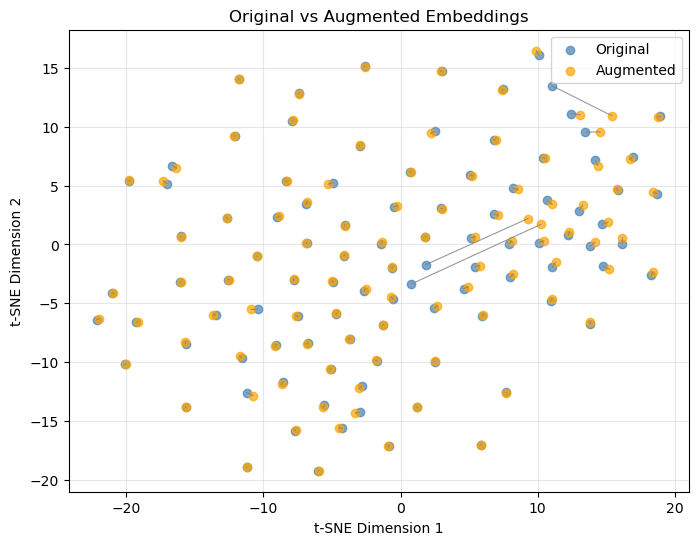

In [92]:
original_embedding = np.array(original_embedding)
augmented_embedding = np.array(augmented_embedding)

n = min(len(original_embedding), len(augmented_embedding))
original_embedding = original_embedding[:n]
augmented_embedding = augmented_embedding[:n]

all_embeddings = np.vstack([original_embedding, augmented_embedding])

tsne = TSNE(n_components=2, perplexity=30, random_state=42, init="pca", learning_rate="auto")
reduced = tsne.fit_transform(all_embeddings)

reduced_original = reduced[:n]
reduced_augmented = reduced[n:]

plt.figure(figsize=(8, 6))
for i in range(n):
    plt.plot(
        [reduced_original[i, 0], reduced_augmented[i, 0]],
        [reduced_original[i, 1], reduced_augmented[i, 1]],
        color='gray', alpha=0.8, linewidth=0.8
    )

plt.scatter(reduced_original[:, 0], reduced_original[:, 1], c='steelblue', label='Original', alpha=0.7)
plt.scatter(reduced_augmented[:, 0], reduced_augmented[:, 1], c='orange', label='Augmented', alpha=0.7)

plt.legend()
plt.title("Original vs Augmented Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(alpha=0.3)
plt.show()

We can conclude that this way of adding a conditionnal information on BERT embedding is poor and don't bring new information in BERT's latent space.

### AggrEmbdADD : How to aggregate condtionnal embedding with document embedding

In [112]:
def agregate_emb(embd1, embd2, func='mean'):
    
    if func == 'mean':
        return (embd1 + embd2) / 2
    
    if func == 'sum':
        return (embd1 + embd2)
    
    if func == 'max':
        return np.maximum(embd1, embd2)
    
    raise Error('Warning ! "func" is not understood ')

In [118]:
n_samples = 3

ds_20ng.dataset[:n_samples]['label_text']

['rec.autos', 'comp.sys.mac.hardware', 'comp.sys.mac.hardware']

In [119]:
conditionnal_information = ds_20ng.dataset[:n_samples]['label_text']
original_samples = ds_20ng.dataset[:n_samples]['text']

In [120]:
conditionnal_embedding = embed_corpus(conditionnal_information, BERTmodel, tk)
original_embedding = embed_corpus(original_samples, BERTmodel, tk)

mean_modified_embedding = agregate_emb(original_embedding, original_embedding, func='mean')
sum_modified_embedding = agregate_emb(original_embedding, original_embedding, func='sum')
max_modified_embedding = agregate_emb(original_embedding, original_embedding, func='max')

In [121]:
sum_modified_embedding.shape

(3, 768)

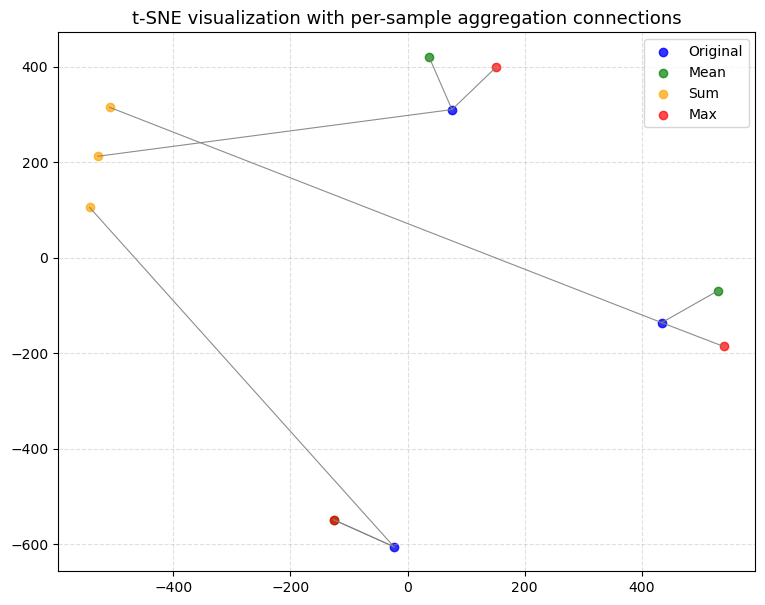

In [128]:
all_embeddings = np.vstack([
    original_embedding,
    mean_modified_embedding,
    sum_modified_embedding,
    max_modified_embedding
])

labels = (
    ["Original"] * len(original_embedding)
    + ["Mean"] * len(mean_modified_embedding)
    + ["Sum"] * len(sum_modified_embedding)
    + ["Max"] * len(max_modified_embedding)
)

tsne = TSNE(n_components=2, random_state=42, perplexity=2, max_iter=1000)
emb_2d = tsne.fit_transform(all_embeddings)

n = len(original_embedding)
orig_2d = emb_2d[0:n]
mean_2d = emb_2d[n:2*n]
sum_2d = emb_2d[2*n:3*n]
max_2d = emb_2d[3*n:4*n]

plt.figure(figsize=(9, 7))
colors = {'Original': 'blue', 'Mean': 'green', 'Sum': 'orange', 'Max': 'red'}

plt.scatter(orig_2d[:, 0], orig_2d[:, 1], c=colors['Original'], label='Original', alpha=0.8)
plt.scatter(mean_2d[:, 0], mean_2d[:, 1], c=colors['Mean'], label='Mean', alpha=0.7)
plt.scatter(sum_2d[:, 0], sum_2d[:, 1], c=colors['Sum'], label='Sum', alpha=0.7)
plt.scatter(max_2d[:, 0], max_2d[:, 1], c=colors['Max'], label='Max', alpha=0.7)

for i in range(n):
    plt.plot(
        [orig_2d[i, 0], mean_2d[i, 0]],
        [orig_2d[i, 1], mean_2d[i, 1]],
        color='gray', alpha=0.9, linewidth=0.8
    )
    plt.plot(
        [orig_2d[i, 0], sum_2d[i, 0]],
        [orig_2d[i, 1], sum_2d[i, 1]],
        color='gray', alpha=0.9, linewidth=0.8
    )
    plt.plot(
        [orig_2d[i, 0], max_2d[i, 0]],
        [orig_2d[i, 1], max_2d[i, 1]],
        color='gray', alpha=0.9, linewidth=0.8
    )

plt.title("t-SNE visualization with per-sample aggregation connections", fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FiMLayer(nn.Module):
    def __init__(self, hidden_dim, condition_dim):
        super().__init__()
        # Génération de gamma et beta à partir du contexte
        self.film_gen = nn.Linear(condition_dim, 2 * hidden_dim)

    def forward(self, h, c):
        gamma_beta = self.film_gen(c)
        gamma, beta = gamma_beta.chunk(2, dim=-1)
        return gamma * h + beta

class MLPWithFiLM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, condition_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.film1 = FiMLayer(hidden_dim, condition_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.film2 = FiMLayer(hidden_dim, condition_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, c):
        h = F.relu(self.fc1(x))
        h = F.relu(self.film1(h, c))
        h = F.relu(self.fc2(h))
        h = F.relu(self.film2(h, c))
        out = self.fc_out(h)
        return out


In [132]:
class FiLM(nn.Module):

    def forward(self, x, gammas, betas):
        gammas = gammas.unsqueeze(2).unsqueeze(3).expand_as(x)
        betas = betas.unsqueeze(2).unsqueeze(3).expand_as(x)
        return (gammas * x) + betas

In [133]:
f = FiLM()
f

FiLM()

## Break Down Documents

In [115]:
def break_down_document(docu, n_split=3):

    words = docu.split()
    part = len(words) // n_split

    sub1 = words[:part]
    sub2 = words[part:2*part]
    sub3 = words[2*part:]
    if len(sub1) == 0 : print(words)

    return " ".join(sub1), " ".join(sub2), " ".join(sub3)


def break_down_corpus(corpus, n_split=3):

    corpus_splited = []

    for docu in corpus:
        corpus_splited.extend(break_down_document(docu, n_split))

    return corpus_splited

In [26]:
nb_samples = 30

hockey_subset = ds_20ng.dataset.filter(lambda x: x['label_text'] == inlier_topic)[:]['text'][:nb_samples]

contex_anomaly_subset = ds_20ng.dataset.filter(
    lambda x: (
        (x["label_text"].split(".")[0] == inlier_topic.split(".")[0]) and
        (x["label_text"].split(".")[1] != inlier_topic.split(".")[1])
      ))[:]['text'][:nb_samples]

indep_anomaly_subset = ds_20ng.dataset.filter(lambda x: x["label_text"].split(".")[0] != inlier_topic.split(".")[0])[:]['text'][:nb_samples]

In [27]:
hockey_subset_splited = break_down_corpus(hockey_subset, n_split=3)
contex_anomaly_subset_splited = break_down_corpus(contex_anomaly_subset, n_split=3)
indep_anomaly_subset_splited = break_down_corpus(indep_anomaly_subset, n_split=3)

In [29]:
hockey_subset_splited_embedding = embed_corpus(hockey_subset_splited, BERTmodel, tk)
contex_anomaly_subset_splited_embedding = embed_corpus(contex_anomaly_subset_splited, BERTmodel, tk)
indep_anomaly_subset_splited_embedding = embed_corpus(indep_anomaly_subset_splited, BERTmodel, tk)

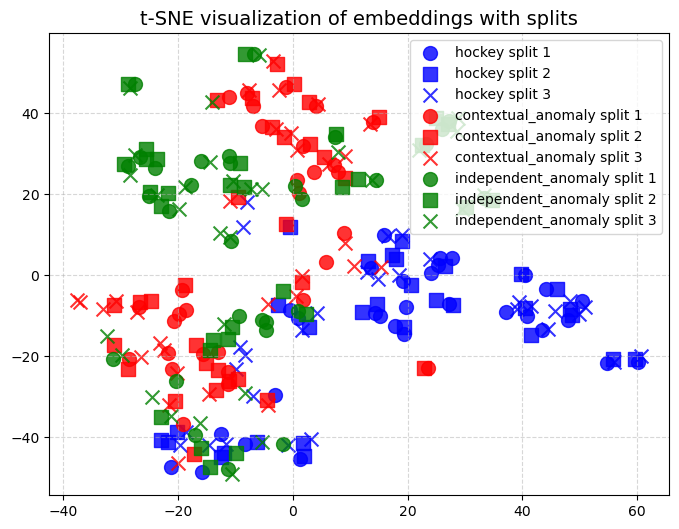

In [36]:
markers = ["o", "s", "x"]
labels_unique = ["hockey", "contextual_anomaly", "independent_anomaly"]
colors = ["blue", "red", "green"]

X = np.vstack([
    hockey_subset_splited_embedding,
    contex_anomaly_subset_splited_embedding,
    indep_anomaly_subset_splited_embedding
])

labels = (
    ["hockey"] * len(hockey_subset_splited_embedding)
    + ["contextual_anomaly"] * len(contex_anomaly_subset_splited_embedding)
    + ["independent_anomaly"] * len(indep_anomaly_subset_splited_embedding)
)

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_tsne = tsne.fit_transform(X)

X_tsne = np.array(X_tsne)

plt.figure(figsize=(8,6))

for i, label in enumerate(labels_unique):
    color = colors[i]
    idx_label = [j for j, l in enumerate(labels) if l == label]

    n_splits = 3
    for split_idx in range(n_splits):
        idx_split = idx_label[split_idx::n_splits] 
        plt.scatter(
            X_tsne[idx_split, 0],
            X_tsne[idx_split, 1],
            label=f"{label} split {split_idx+1}",
            color=color,
            marker=markers[split_idx],
            s=100,
            alpha=0.8
        )

plt.title("t-SNE visualization of embeddings with splits", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [38]:
logs = []

for i, hockey_emb_part in enumerate(hockey_subset_splited_embedding):
    
    for j, contex_emb_part in enumerate(contex_anomaly_subset_splited_embedding):
    
        logs.append( (i, j, ev.cosinus_similarity(hockey_emb_part,contex_emb_part)) )
        
logs = np.array(logs)

In [50]:
similarities = logs[:,2]
indexes = np.argsort(similarities)[::-1]

k = 2

k_closest = indexes[:k]
k_distant = indexes[-k:]

In [51]:
selected_hockey_emb = np.array(hockey_subset_splited).reshape(-1,1)[logs[k_distant][:,0].astype(int)]
selected_contex_emb = np.array(contex_anomaly_subset_splited)[logs[k_distant][:,1].astype(int)]

In [52]:
print(selected_hockey_emb)
print()
print()
print(selected_contex_emb)

[['beat the rangers in overtime on last friday']
 ['testing']]


['crankshaft contaminating the engine etc when the overhaul was done last week it required new crankshaft one new cam shaft has two because the camshaft shattered when they tried to mill it the camshaft took weeks to get because it is on national back order everything on the engine is unique to the year they went to a new design in parts are very expensive'
 'crankshaft contaminating the engine etc when the overhaul was done last week it required new crankshaft one new cam shaft has two because the camshaft shattered when they tried to mill it the camshaft took weeks to get because it is on national back order everything on the engine is unique to the year they went to a new design in parts are very expensive']


In [53]:
selected_hockey_emb = np.array(hockey_subset_splited).reshape(-1,1)[logs[k_closest][:,0].astype(int)]
selected_contex_emb = np.array(contex_anomaly_subset_splited)[logs[k_closest][:,1].astype(int)]

In [54]:
print(selected_hockey_emb)
print()
print()
print(selected_contex_emb)

[['neither both are smarter than this i might not be great in math']
 ['neither both are smarter than this i might not be great in math']]


['i had the same problem in my mx luckily i'
 'i agree six hour long stretches behind the wheel really make me thirsty']


## Document Split Order Prediction

In [256]:
bert_model_name = "distilbert-base-uncased"

In [257]:
class SplitDocumentDataset(Dataset):
    def __init__(self, documents, n_splits=3, tokenizer=None):
        
        self.documents = documents
        self.n_splits = n_splits
        self.tokenizer = tokenizer if tokenizer else lambda x: x.split()
        self.perm_orders = list(permutations(range(n_splits)))  # all possible orders

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, idx):
        doc = self.documents[idx]
        tokens = self.tokenizer(doc)
        split_size = max(1, len(tokens) // self.n_splits)
        splits = [" ".join(tokens[i*split_size:(i+1)*split_size]) for i in range(self.n_splits)]
        
        perm = random.choice(self.perm_orders)
        permuted_splits = [splits[i] for i in perm]

        return permuted_splits, perm

def collate_fn(batch):
    splits_batch = [item[0] for item in batch]
    perm_batch = [item[1] for item in batch]   

    return splits_batch, perm_batch

In [258]:
class BERTWrapper(nn.Module):
    def __init__(self, model_name, device=device):
        super().__init__() 
        
        self.module_name = model_name
        self.device = device
        self.bert_model = AutoModel.from_pretrained(model_name).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
    def forward(self, corpus):
        
        inputs = self.tokenizer(corpus, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.bert_model(**inputs)

        return outputs.last_hidden_state[:, 0, :]

In [259]:
class SplitOrderPredictor(nn.Module):
    def __init__(self, bert_wrapper, embed_dim, n_splits, hidden_dims, device):
        super().__init__()
        self.device = device
        self.bert_wrapper = bert_wrapper
        self.n_splits = n_splits

        dims = [embed_dim] + hidden_dims

        layers = []
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
        
        self.mlp = nn.Sequential(*layers).to(self.device)

        self.fc_f = nn.Linear(dims[-1], n_splits).to(self.device)

    def forward(self, splits_encoded):

        x = [self.bert_wrapper(s) for s in splits_encoded]
        x = torch.stack(x, dim=0)

        x = self.mlp(x)
        
        x = self.fc_f(x)
        return x

In [260]:
inlier_cat = "comp.windows.x"
nb_all_documents = 1200
ratio_anomaly = 0.3

intlier_dataset = ds_20ng.dataset.filter(lambda x: x['label_text'] == inlier_cat).shuffle(seed=42).select(range(int(nb_all_documents * (1-ratio_anomaly))))
contex_anomaly_dataset = ds_20ng.dataset.filter(
    lambda x: (
        (x["label_text"].split(".")[0] == inlier_cat.split(".")[0]) and
        (x["label_text"].split(".")[1] != inlier_cat.split(".")[1])
      )
    ).shuffle(seed=42).select(range(int(nb_all_documents * ratio_anomaly))) 

indep_anomaly_subset = ds_20ng.dataset.filter(lambda x: x["label_text"].split(".")[0] != inlier_cat.split(".")[0]).shuffle(seed=42).select(range(int(nb_all_documents * ratio_anomaly))) 

dataset_complet = concatenate_datasets([intlier_dataset, indep_anomaly_subset])
corpus_complet = dataset_complet['text']
labels_complet = np.array(dataset_complet['label_text'])

In [261]:
dataset = SplitDocumentDataset(corpus_complet, n_splits=3)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [262]:
bert_wrapper = BERTWrapper("distilbert-base-uncased")

embed_dim = 768
n_splits = 3
hidden_dim = 128
nb_epochs = 50
hidden_dims = [256,128,64]
losses = []


SOP = SplitOrderPredictor(bert_wrapper, embed_dim, n_splits, hidden_dims, device).to(device)
# print(SOP, end="\n\n")
optimizer = torch.optim.Adam(SOP.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in tqdm(range(nb_epochs)):
    for splits_encoded, perm_labels in dataloader:
    
        perm_labels = torch.tensor(np.array(perm_labels)).to(device)
        
        optimizer.zero_grad()
        outputs = SOP(splits_encoded)
    #     print(outputs.shape)
    #     break
    # break
        loss = criterion(outputs.view(-1, n_splits), perm_labels.view(-1))
        loss.backward()
        optimizer.step()
    # print(f"Epoch {epoch+1} loss: {loss.item():.4f}")
    losses.append(loss.item())

print("\n Training finished!")


100%|██████████| 50/50 [04:38<00:00,  5.57s/it]


 Training finished!


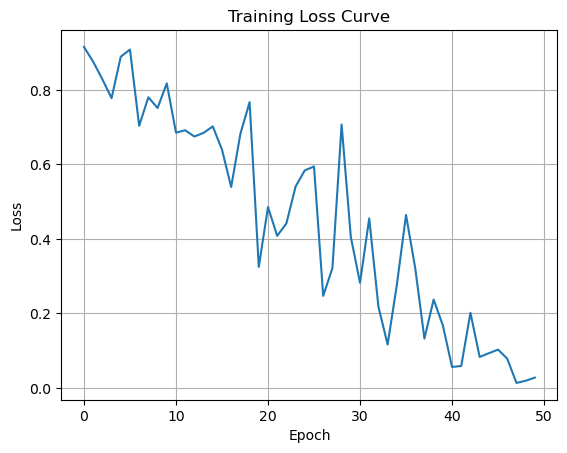

In [263]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

In [264]:
SOP.mlp

Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
)

In [265]:
news_embeddings = []
bert_embeddings = []
outputs = []

for splits_encoded, perm_labels in dataloader:
    
    x = [SOP.bert_wrapper(s) for s in splits_encoded]
    x = torch.stack(x, dim=0)
    
    bert_embeddings.extend(x.detach().cpu().numpy())
    news_embeddings.extend(SOP.mlp[:5](x).detach().cpu().numpy())
    outputs.extend(SOP(splits_encoded))    

In [266]:
news_embeddings = np.array(news_embeddings)
bert_embeddings = np.array(bert_embeddings)

print(news_embeddings.shape)
print(bert_embeddings.shape)

print(len(labels_complet))

(1200, 3, 64)
(1200, 3, 768)
1200


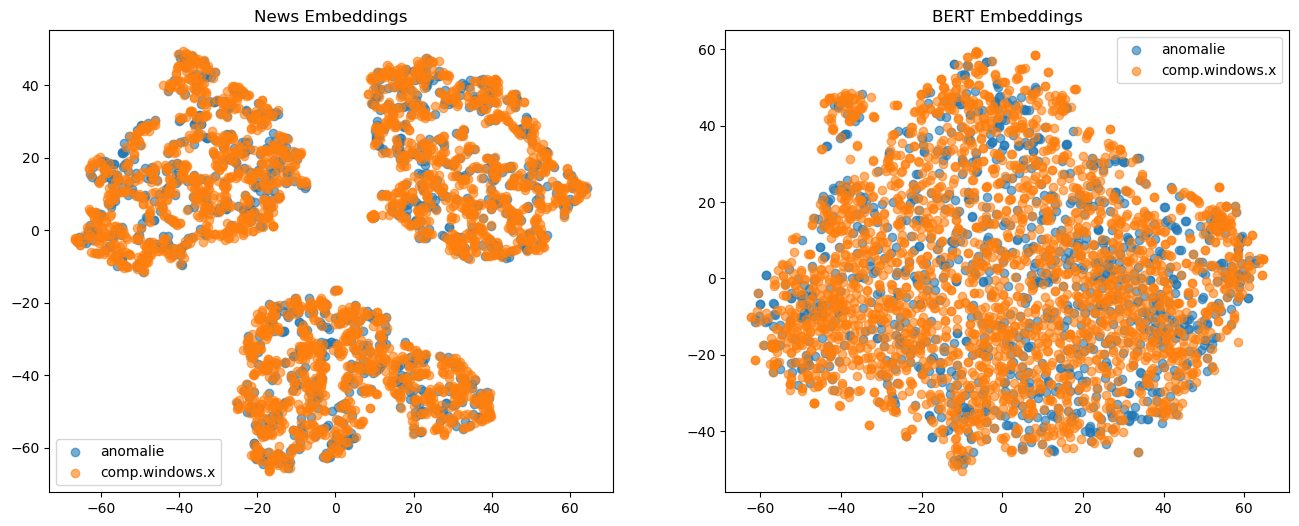

In [267]:
def prepare_embeddings_and_labels(embeddings, labels):
    
    N, n_splits, dim = embeddings.shape
    embeddings_flat = embeddings.reshape(N * n_splits, dim)
    
    labels_flat = np.repeat(labels, n_splits)
    colors_flat = np.where(labels_flat == intlier_cat, intlier_cat, "anomalie")
    
    return embeddings_flat, colors_flat

def plot_tsne(embeddings, colors, title, ax):
    tsne = TSNE(n_components=2, random_state=42)
    X_embedded = tsne.fit_transform(embeddings)
    
    for label in np.unique(colors):
        idx = colors == label
        ax.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=label, alpha=0.6)
    
    ax.set_title(title)
    ax.legend()

news_flat, news_colors = prepare_embeddings_and_labels(news_embeddings, labels_complet)
bert_flat, bert_colors = prepare_embeddings_and_labels(bert_embeddings, labels_complet)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_tsne(news_flat, news_colors, "News Embeddings", axes[0])
plot_tsne(bert_flat, bert_colors, "BERT Embeddings", axes[1])

plt.show()

In [268]:
outputs[0]

# grande variance --> intlier 
# peu de variance --> hesitation --> anomalie

tensor([[ 4.3901, -3.9572, -2.9380],
        [-2.8862, -2.4116,  4.6028],
        [-1.4142,  6.2007, -6.2883]], device='cuda:0',
       grad_fn=<UnbindBackward0>)

In [269]:
def get_variance(outputs):
    
    variances = []
    
    for i in range(len(outputs)):

        proba = torch.softmax(outputs[i],dim=1)
        # variance for each split
        variances.extend(proba.var(dim=1))
        
    variances_ = []    
    for var in variances:
        
        variances_.append(var.item())
        
    return torch.tensor(np.array(variances_))

In [270]:
variances_per_split = get_variance(outputs)
print(variances_per_split)
variances_per_document = variances_per_split.view(-1, 3).mean(dim=1)
variances_per_document

tensor([0.3324, 0.3319, 0.3328,  ..., 0.3296, 0.3197, 0.3327],
       dtype=torch.float64)


tensor([0.3324, 0.3230, 0.3323,  ..., 0.3327, 0.3286, 0.3273],
       dtype=torch.float64)

In [271]:
labels_complet

array(['comp.windows.x', 'comp.windows.x', 'comp.windows.x', ...,
       'rec.autos', 'talk.politics.misc', 'rec.motorcycles'], dtype='<U22')

In [276]:
def anomaly_accuracy(labels, variances, threshold, inlier_cat):

    preds = [1 if v < threshold else 0 for v in variances]
    trues = [1 if l != inlier_cat else 0 for l in labels]

    correct = sum(p == t for p, t in zip(preds, trues))
    accuracy = correct / len(labels)
    
    precision = precision_score(trues, preds)
    recall = recall_score(trues, preds)
    f1 = f1_score(trues, preds)
    return accuracy, precision, recall, f1


In [278]:
threshold = 0.25
accuracy, precision, recall, f1 = anomaly_accuracy(labels_complet, variances_per_document, threshold, inlier_cat)
accuracy, precision, recall, f1

(0.6958333333333333,
 0.2727272727272727,
 0.008333333333333333,
 0.016172506738544475)

In [274]:
variances_per_document.mean()

tensor(0.3235, dtype=torch.float64)

In [275]:
variances_per_document.var()

tensor(0.0003, dtype=torch.float64)

## Document split prediction & his position : full pipeline

# BERT Embedding

In [196]:
# model_name = "sentence-transformers/all-MiniLM-L6-v2"
model_name = "distilbert-base-uncased"

extractor = be.BERTEmbeddingExtractor(model_name,device)
train_dataset_AD_independent_with_embeds = be.extract_embeddings(train_dataset_AD_independent, extractor, batch_size=32)

train_dataset_AD_independent_with_embeds

In [197]:
# model_name = "sentence-transformers/all-MiniLM-L6-v2"
model_name = "distilbert-base-uncased"

extractor = be.BERTEmbeddingExtractor(model_name,device)
train_dataset_AD_contexual_with_embeds = be.extract_embeddings(train_dataset_AD_contexual, extractor, batch_size=32)

train_dataset_AD_contexual_with_embeds

In [198]:
train_dataset_AD_contexual_with_embeds.dataset

Dataset({
    features: ['text', 'label', 'label_text', 'anomaly_label', 'CLS', 'embedding', 'embedding_mean'],
    num_rows: 1200
})

#  Modelisation

## Ours

## Baseline

### OCSVM

In [199]:
X_contex = np.array(train_dataset_AD_contexual_with_embeds.dataset['embedding_mean'])
y_contex = np.array(train_dataset_AD_contexual_with_embeds.dataset['anomaly_label'])  

ocsvm_contex, (ocsvm_auc_test_contex, ocsvm_f1_test_contex, ocsvm_precision_test_contex, ocsvm_recall_test_contex) = baseline.ocsvm_pipeline(X_contex, y_contex, kernel='rbf', gamma='scale', nu=0.1, test_size=0.2, verbose=True, random_state=42)

=== One-Class SVM Baseline ===

Testing Results
AUC:        0.7948
F1-score:   0.4752
Precision:  0.4528
Recall:     0.5000


In [200]:
X_indep = np.array(train_dataset_AD_independent_with_embeds.dataset['embedding_mean'])
y_indep = np.array(train_dataset_AD_independent_with_embeds.dataset['anomaly_label'])  

ocsvm_indep, (ocsvm_auc_test_indep, ocsvm_f1_test_indep, ocsvm_precision_test_indep, ocsvm_recall_test_indep) = baseline.ocsvm_pipeline(X_indep, y_indep, kernel='rbf', gamma='scale', nu=0.1, test_size=0.2, verbose=True, random_state=42)

=== One-Class SVM Baseline ===

Testing Results
AUC:        0.7250
F1-score:   0.3750
Precision:  0.3750
Recall:     0.3750


# Evaluation